<a href="https://colab.research.google.com/github/Bigulac/MOAR-Dense_network/blob/main/MOAR_Dense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Потпуно повезана неурална мрежа

In [2]:
import os
import numpy as np
import keras
from keras import layers
from keras import ops
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [3]:
# Skida dataset sa interneta
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip

# Izbacuje loše slike
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Obrisano {num_skipped} slika.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  84.2M      0  0:00:09  0:00:09 --:--:-- 54.6M
Obrisano 1590 slika.


In [4]:
image_size = (180, 180)
batch_size = 128

# Pravi skup slika za treninranje modela i validaciju
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
'''
# Prikaz slika iz dataseta
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title("Pas" if int(labels[i]) else "Mačka")
        plt.axis("off")
'''
# Povećanje skupa malim modifikacijama postojećih slika
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images
'''
# Prikaz kako izgledaju slike nakon modifikacija
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")
'''
# Primena gornje funkcije na trening skup
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


**Одавде се код разликује.**

# Пример неуралне мреже са потпуно повезаним слојевима.
Дати су примери са различитом дубином и ширином.
На крају је изведен закључак на основу приказане ефикасности модела.

 **Модел дубоке мреже**

In [5]:
inputs = keras.Input(shape=image_size + (3,))

# inputs.shape

x = layers.Rescaling(1.0 / 255)(inputs)
x = layers.Flatten()(x)
'''
dense = layers.Dense(64, activation="relu")
x = dense(inputs)'''

x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)

outputs = layers.Dense(1, activation="softmax")(x)

model_deep_10 = keras.Model(inputs=inputs, outputs=outputs, name="deep_dense_model")

model_deep_10.summary()

# keras.utils.plot_model(model, show_shapes=True)


Model: "deep_dense_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 97200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,441,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,534,657 (47.82 MB)

 Trainable params: 12,534,657 (47.82 MB)

 Non-trainable params: 0 (0.00 B)

Тренирање модела:

In [15]:
epochs = 10

model_deep_10.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_deep_10 = model_deep_10.fit(train_ds, validation_data=val_ds, epochs=epochs)


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 103s 678ms/step - accuracy: 0.4971 - loss: 0.9242 - val_accuracy: 0.5043 - val_loss: 0.7135
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 140s 668ms/step - accuracy: 0.4977 - loss: 0.6874 - val_accuracy: 0.5043 - val_loss: 0.6513
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 98s 665ms/step - accuracy: 0.4957 - loss: 0.6700 - val_accuracy: 0.5043 - val_loss: 0.6487
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 136s 621ms/step - accuracy: 0.4940 - loss: 0.6713 - val_accuracy: 0.5043 - val_loss: 0.6437
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 146s 648ms/step - accuracy: 0.4990 - loss: 0.6590 - val_accuracy: 0.5043 - val_loss: 0.6347
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 95s 646ms/step - accuracy: 0.4987 - loss: 0.6615 - val_accuracy: 0.5043 - val_loss: 0.6432
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 137s 614ms/step - accuracy: 0.4970 - loss: 0.6602 - val_accuracy: 0.5043 - val_loss: 0.6395
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 142s 617ms/step - accuracy: 0.4995 - l

График зависности прецизности модела од броја епоха

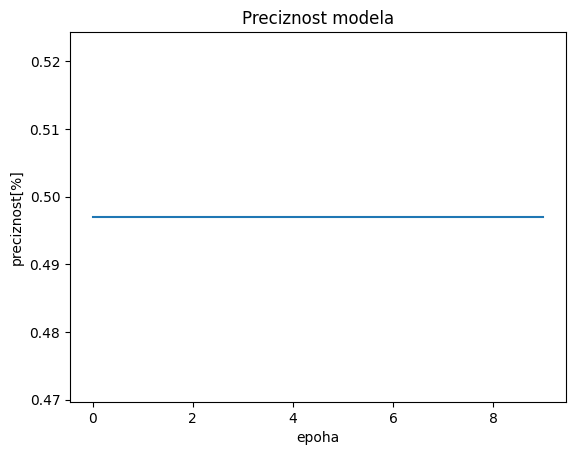

In [6]:
plt.plot(history_deep_10.history['accuracy'])
plt.title('Preciznost modela: Duboka mreža')
plt.ylabel('preciznost[%]')
plt.xlabel('Broj epoha')
# plt.legend(['training'], loc='best')
plt.show()

# Napraviti da pravljenje modela bude funkcija kako bi mogao da napraviš
# više modela sa različitim brojem epoha %%

**Модел широке мреже**

In [8]:
inputs = keras.Input(shape=image_size + (3,))

# inputs.shape

x = layers.Rescaling(1.0 / 255)(inputs)
x = layers.Flatten()(x)
'''
dense = layers.Dense(64, activation="relu")
x = dense(inputs)'''

x = layers.Dense(2048, activation="relu")(x)
x = layers.Dense(2048, activation="relu")(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)

outputs = layers.Dense(1, activation="softmax")(x)

model_wide_10 = keras.Model(inputs=inputs, outputs=outputs, name="wide_dense_model")

model_wide_10.summary()

epochs = 10

model_wide_10.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_wide_10 = model_wide_10.fit(train_ds, validation_data=val_ds, epochs=epochs)

Model: "Dense_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 97200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 2048)                │     199,067,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2048)                │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 205,493,505 (783.90 MB)

 Trainable params: 205,493,505 (783.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 601s 4s/step - accuracy: 0.4973 - loss: 11.0035 - val_accuracy: 0.5043 - val_loss: 0.6580
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 651s 4s/step - accuracy: 0.4951 - loss: 0.6908 - val_accuracy: 0.5043 - val_loss: 0.6874
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 668s 4s/step - accuracy: 0.4972 - loss: 0.6799 - val_accuracy: 0.5043 - val_loss: 0.6451
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 626s 4s/step - accuracy: 0.4985 - loss: 0.6646 - val_accuracy: 0.5043 - val_loss: 0.6398
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 616s 4s/step - accuracy: 0.4990 - loss: 0.6568 - val_accuracy: 0.5043 - val_loss: 0.6640
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 627s 4s/step - accuracy: 0.4984 - loss: 0.6599 - val_accuracy: 0.5043 - val_loss: 0.6453
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 606s 4s/step - accuracy: 0.4974 - loss: 0.6550 - val_accuracy: 0.5043 - val_loss: 0.6314
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 606s 4s/step - accuracy: 0.4979 - loss: 0.6463 - val_acc

In [11]:
plt.plot(history_wide_10.history['accuracy'])
plt.title('Preciznost modela: Široka mreža')
plt.ylabel('preciznost[%]')
plt.xlabel('Broj epoha')
# plt.legend(['training'], loc='best')
plt.show()


NameError: name 'history_wide' is not defined

**Дубоки модел са више епоха - 25**

In [6]:
epochs = 25

model_deep_25 = model_deep_10

model_deep_25.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_deep_25 = model_deep_25.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 18/147 ━━━━━━━━━━━━━━━━━━━━ 2:25 1s/step - accuracy: 0.5013 - loss: 1.4059

KeyboardInterrupt: 

In [ ]:
plt.plot(history_deep_25.history['accuracy'])
plt.title('Preciznost modela: Duboka mreža, 25 epoha')
plt.ylabel('preciznost[%]')
plt.xlabel('Broj epoha')
# plt.legend(['training'], loc='best')
plt.show()